Import required modules and set up matplotlib display properties. Set up variables.

In [48]:
import astropy.units as u
import sunpy.map
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as ms
from split_pol_thresh import split_pol_thresh
from find_regions import find_regions
from write_props import write_props
%matplotlib notebook
plt.rcParams['figure.figsize'] = 11, 11
plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings('ignore')

# Choose threshold. Any magnetic fields under this level (in Gauss) will be ignored.
threshold = 250 # Gauss

Load magnetogram data into a SunPy map object.

In [3]:
file_to_load = '/Users/fraser/Data/HMImag/hmi.M_720s.20160708_000000_TAI.3.magnetogram.fits' # insert HMI FITS file path between quotes

hmi = sunpy.map.Map(file_to_load)

Exception ignored in: <bound method FITS_rec.__del__ of FITS_rec([(array([84,  0], dtype=int32),), (array([84, 84], dtype=int32),),
       (array([ 84, 168], dtype=int32),), ...,
       (array([      84, 13827676], dtype=int32),),
       (array([      84, 13827760], dtype=int32),),
       (array([      84, 13827844], dtype=int32),)], 
      dtype=(numpy.record, [('COMPRESSED_DATA', '>i4', (2,))]))>
Traceback (most recent call last):
  File "/Users/fraser/anaconda/lib/python3.5/site-packages/astropy/io/fits/fitsrec.py", line 640, in __del__
    del self._coldefs
  File "/Users/fraser/anaconda/lib/python3.5/site-packages/astropy/io/fits/fitsrec.py", line 637, in _coldefs
    raise AttributeError(exc.args[0])
AttributeError: _coldefs


Display HMI magnetogram with coordinate grid overplotted.

<IPython.core.display.Javascript object>


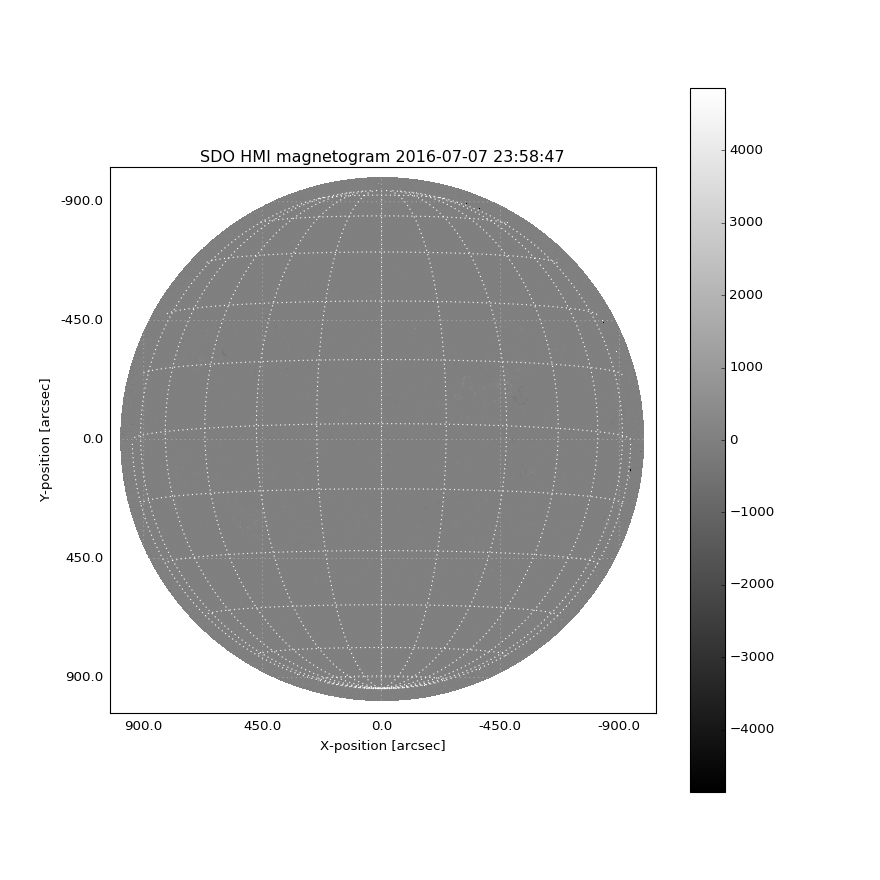

/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
/Users/fras

In [5]:
hmi.peek(draw_grid=True)

Create submap and split submap into positive and negative magnetic field so that fragments can be found independently using the same code.

In [6]:
hmi_submap = hmi.submap([-225, -590]*u.arcsec, [-342, -90]*u.arcsec) # Change submap coords in arcsecs from disk centre

submap_data = np.copy(hmi_submap.data)

# Zero all edges to remove edge effects
submap_data[0, :] = 0
submap_data[-1, :] = 0
submap_data[:, 0] = 0
submap_data[:, -1] = 0

# Split into positive and negative data frames
pos_data = split_pol_thresh(submap_data, threshold, 'pos')
neg_data = split_pol_thresh(submap_data, threshold, 'neg')

<IPython.core.display.Javascript object>


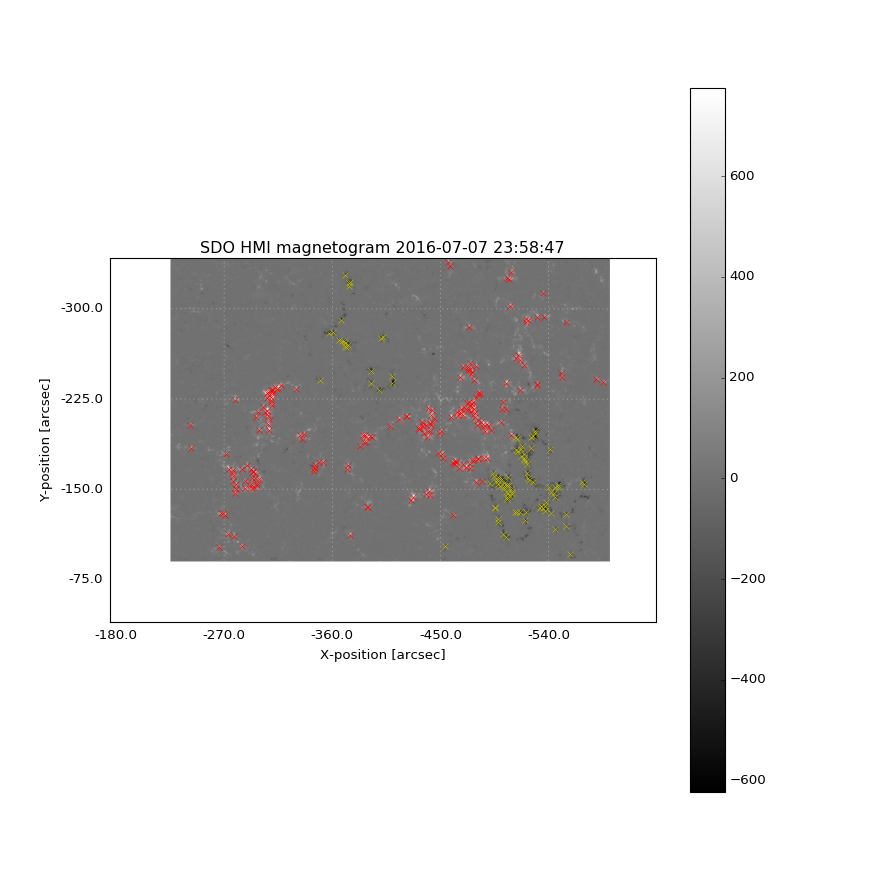

/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/Users/fraser/anaconda/lib/python3.5/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
/Users/fras

In [7]:
pos_region_frame, num_pos_regions = find_regions(pos_data)
neg_region_frame, num_neg_regions = find_regions(neg_data)

pos_labeled_frame, pos_num_labels = ms.label(pos_region_frame.astype(int), return_num=True, connectivity=2)
neg_labeled_frame, neg_num_labels = ms.label(neg_region_frame.astype(int), return_num=True, connectivity=2)

pos_properties = ms.regionprops(pos_labeled_frame, intensity_image=pos_data)
neg_properties = ms.regionprops(neg_labeled_frame, intensity_image=neg_data)

hmi_submap.peek()

for region in pos_properties:
    x = region.centroid[1]
    y = region.centroid[0]
    plt.plot(x, y, 'rx')
    
for region in neg_properties:
    x = region.centroid[1]
    y = region.centroid[0]
    plt.plot(x, y, 'yx')

Save the positive and negative region data in a file format suitable for parsing in time.

In [51]:
write_props(pos_properties, 'p', 1, hmi.date)
write_props(neg_properties, 'n', 1, hmi.date)